# Import Libraries

In [164]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [93]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Request Data from YF

In [40]:
# History(): get historicals for one Stock
# stock = yf.Ticker('TSLA')
# stock_historical = Stock.history(
#     period="5mo", 
#     interval="1d",
# )

# Download(): get historicals for multiple Stocks
# In this case, I just need one for demo
stock_list = ['TSLA']
stock_historical = yf.download(
    stock_list, 
    period="8mo",
    interval="1d"
)

stock_historical.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-06,1001.510010,1021.640015,950.500000,1009.010010,1009.010010,27221000
2021-12-07,1044.199951,1057.670044,1026.810059,1051.750000,1051.750000,18694900
2021-12-08,1052.709961,1072.380005,1033.000000,1068.959961,1068.959961,13968800
2021-12-09,1060.640015,1062.489990,1002.359985,1003.799988,1003.799988,19812800
2021-12-10,1008.750000,1020.979980,982.530029,1017.030029,1017.030029,19888100


In [86]:
# Save to local
# stock_historical.to_csv("./stock_historicals.csv") # not necessary this case

# Calculate EMAs
> 12Day for short-term (ST_EMA) <br>
> 26Day for long-term (LT_EMA)
>
> $$EMA_{Today} = Close_{Today} \cdot Multiplier + EMA_{yesterday} \cdot (1-Multiplier)$$
> $$Multiplier = \frac{Smoothing}{1 + Days}$$

,Date,Close,ST_EMA,LT_EMA
0,2021-12-06,1009.010010,1009.010010,1009.010010
1,2021-12-07,1051.750000,1015.585393,1012.175935
2,2021-12-08,1068.959961,1023.796865,1016.382159
3,2021-12-09,1003.799988,1020.720422,1015.450146
4,2021-12-10,1017.030029,1020.152669,1015.567175


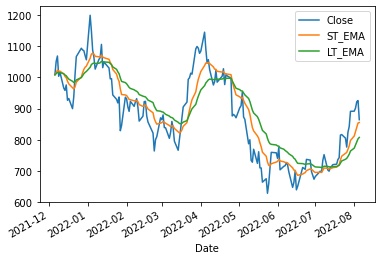

In [134]:
# MACD df with only date and close
MACD_df = stock_historical[["Close"]]
MACD_df.reset_index(inplace=True)
MACD_df.head()

# initial EMA (close price)
init_EMA = MACD_df.Close[0]
smoothing = 2

######################################################################################

# short term EMA (12-days EMA)
ST_period = 12
ST_multiplier = smoothing / (1 + ST_period)
ST_EMA = [init_EMA]

for i in range(1, len(MACD_df['Close'])):
    # Close price is at column 1
    ST_EMA.append( MACD_df.iloc[i,1]*ST_multiplier + ST_EMA[i-1]*(1-ST_multiplier) )

#MACD_df.insert(loc=2, column='ST_EMA', value=pd.Series(ST_EMA))
MACD_df['ST_EMA'] = ST_EMA

######################################################################################

# long term EMA (12-days EMA)
LT_period = 26
LT_multiplier = smoothing / (1 + LT_period)
LT_EMA = [init_EMA]

for i in range(1, len(MACD_df['Close'])):
    # Close price is at column 1
    LT_EMA.append( MACD_df.iloc[i,1]*LT_multiplier + LT_EMA[i-1]*(1-LT_multiplier) )

#MACD_df.insert(loc=2, column='LT_EMA', value=pd.Series(LT_EMA))
MACD_df['LT_EMA'] = LT_EMA

######################################################################################

# df check
display(MACD_df.head())

# plot check
MACD_df.set_index('Date', inplace=True)
MACD_df.plot()
MACD_df.reset_index(inplace=True)

# Calculate MACD, Signal line, and Histogram values
> MACD is (ST_EMA - LT_EMA) <br>
> Signal line is a 9-day EMA of the MACD <br>
> Histogram values is (MACD - Signal)

In [140]:
# MACD
MACD_df['MACD'] = MACD_df['ST_EMA'] - MACD_df['LT_EMA']

################################################################################
# Signal line
Signal_period = 9
Signal_multiplier = smoothing / (1 + Signal_period)
Signal = [0] #The initial EMA for MACD is considered 0 here

for i in range(1, len(MACD_df['Close'])):
    # MACD is at column 4
    Signal.append( MACD_df.iloc[i,4]*Signal_multiplier + Signal[i-1]*(1-Signal_multiplier) )

MACD_df['Signal'] = Signal

################################################################################
# Histogram
MACD_df['Diff'] = MACD_df['MACD'] - MACD_df['Signal']

# df check
MACD_df

,Date,Close,ST_EMA,LT_EMA,MACD,Signal,Diff
0,2021-12-06,1009.010010,1009.010010,1009.010010,0.000000,0.000000,0.000000
1,2021-12-07,1051.750000,1015.585393,1012.175935,3.409458,0.681892,2.727566
2,2021-12-08,1068.959961,1023.796865,1016.382159,7.414706,2.028454,5.386251
3,2021-12-09,1003.799988,1020.720422,1015.450146,5.270276,2.676819,2.593457
4,2021-12-10,1017.030029,1020.152669,1015.567175,4.585495,3.058554,1.526941
...,...,...,...,...,...,...,...
163,2022-08-01,891.830017,812.179041,773.306531,38.872509,22.327508,16.545001
164,2022-08-02,901.760010,825.960728,782.821604,43.139124,26.489831,16.649293
165,2022-08-03,922.190002,840.765232,793.145189,47.620043,30.715874,16.904169
166,2022-08-04,925.900024,853.862892,802.978880,50.884012,34.749501,16.134511


# Plot

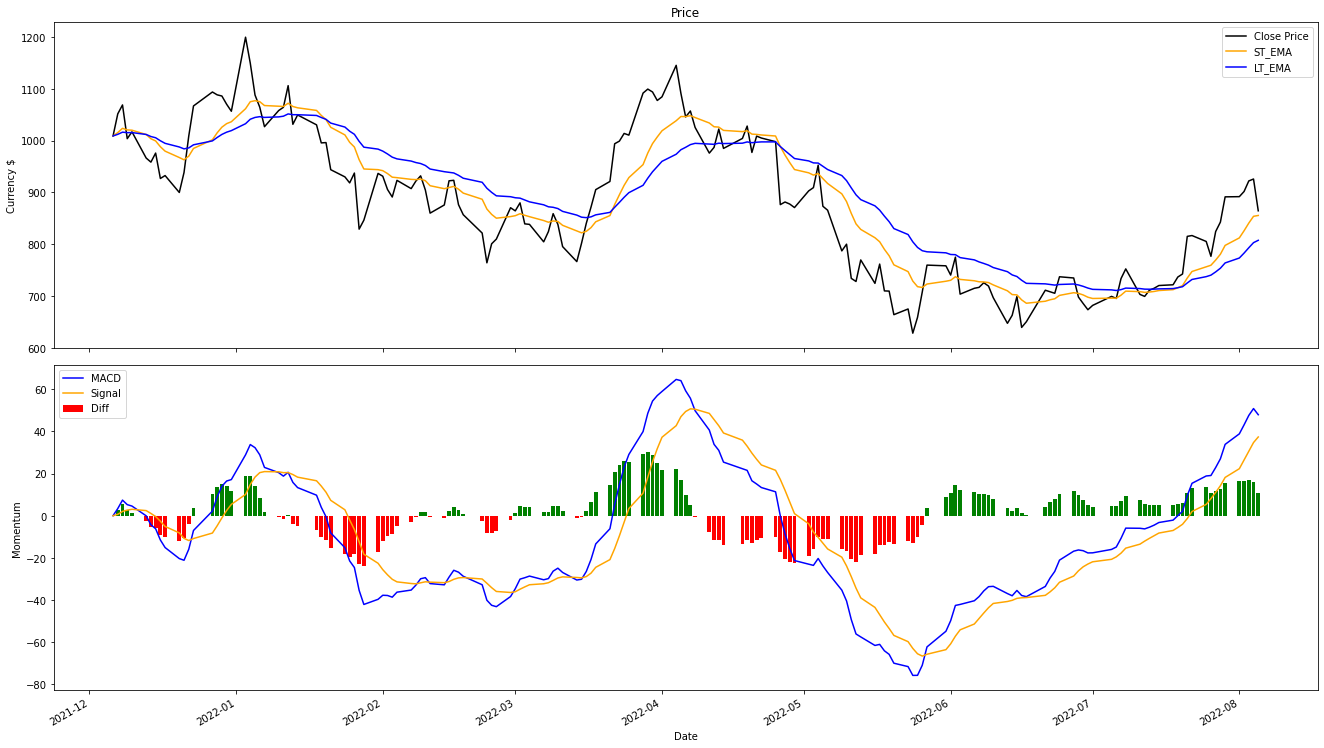

In [172]:
MACD_df.set_index('Date', inplace=True)
# 2row-1col graph with 
#    Price, ST/LT EMA at top 
#    and MACD, Signal, Hist at bottom
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(18.5, 10.5)

ax1.plot(MACD_df.index, MACD_df.Close, color='black', label='Close Price')
ax1.plot(MACD_df.index, MACD_df.ST_EMA, color='orange', label='ST_EMA')
ax1.plot(MACD_df.index, MACD_df.LT_EMA, color='blue', label='LT_EMA')

ax2.plot(MACD_df.index, MACD_df.MACD, color='blue', label='MACD')
ax2.plot(MACD_df.index, MACD_df.Signal, color='orange', label='Signal')
MACD_df['positive'] = MACD_df['Diff'] > 0 # dummy column to separate colors
ax2.bar(MACD_df.index, MACD_df.Diff, 
        color=MACD_df.positive.map({True: 'green', False: 'red'}), )

ax1.legend()
ax1.set_title('Price')
ax1.set_ylabel('Currency $')

ax2.legend()
ax2.set_xlabel('Date')
ax2.set_ylabel('Momentum')

fig.autofmt_xdate()

plt.tight_layout()
plt.show()
fig.savefig('MACD.png')